This notebook is divided into two sections, where an analysis will be carried out on Forest Area, and subsequently, on Co2 emissions by country.

Note: The questions have been separated into blocks for each analysis performed.

## **FORESTED AREA (%) ANALYSIS**

Firstly, we will import the necessary libraries and load the global information dataset (used in the 01_introduction_and_processing.ipynb notebook), which provides information for several countries in 2023.

In [65]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import pycountry_convert as pc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.cluster import DBSCAN

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

We select the columns pertinent to the analysis, excluding the others:

In [66]:
world_df: pl.DataFrame = pl.read_csv("../data/cleaned/data.csv", ignore_errors=True)

columns_to_keep = [
    "Country",
    "Abbreviation",
    "Forested Area (%)",
    "Life expectancy",
    "Co2-Emissions",
    "Latitude",
    "Longitude",
    "GDP",
]

world_df = world_df.drop(
    [col for col in world_df.columns if col not in columns_to_keep]
)
world_df

Country,Abbreviation,Co2-Emissions,Forested Area (%),GDP,Life expectancy,Latitude,Longitude
str,str,f64,f64,f64,f64,f64,f64
"""Afghanistan""","""AF""",8672.0,2.1,1.9101e10,64.5,33.93911,67.709953
"""Albania""","""AL""",4536.0,28.1,1.5278e10,78.5,41.153332,20.168331
"""Algeria""","""DZ""",150006.0,0.8,1.6999e11,76.7,28.033886,1.659626
"""Andorra""","""AD""",469.0,34.0,3.1541e9,84.04,42.506285,1.521801
"""Angola""","""AO""",34693.0,46.3,9.4635e10,60.8,-11.202692,17.873887
…,…,…,…,…,…,…,…
"""Venezuela""","""VE""",164175.0,52.7,4.8236e11,72.1,6.42375,-66.58973
"""Vietnam""","""VN""",192668.0,48.1,2.6192e11,75.3,14.058324,108.277199
"""Yemen""","""YE""",10609.0,1.0,2.6914e10,66.1,15.552727,48.516388


Let's check missing values ​​for each column:

In [67]:
missing_values = world_df.select(
    [
        pl.col(col).is_null().sum().alias(f"{col} missing values")
        for col in world_df.columns
    ]
)
missing_values

Country missing values,Abbreviation missing values,Co2-Emissions missing values,Forested Area (%) missing values,GDP missing values,Life expectancy missing values,Latitude missing values,Longitude missing values
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


Which countries do these missing values ​​correspond to?

In [68]:
null_values = None
if missing_values["Forested Area (%) missing values"][0] != 0:
    null_values = world_df.filter(
        world_df["Forested Area (%)"].is_null() | world_df["Forested Area (%)"].is_nan()
    )
null_values.select(
    ["Country", "Forested Area (%)"]
) if null_values is not None else None

In order to complete the information of the countries mentioned above, we are going to use a Kaggle dataset with interesting information on the forest area in various years from 1990 to 2020. Since this dataset presents information for more countries, cities or globally, we are going to restrict the dataset, filtering only those countries that appear in the global information dataset. We also discard columns from the new data set that hold no relevance to the investigation.

Source: https://www.kaggle.com/datasets/kanchana1990/global-forest-insights-1990-2020-fao

In [69]:
forest_df: pl.DataFrame = pl.read_csv(
    "../data/raw/ambiental_analysis/Forest_Area.csv", ignore_errors=True
)
forest_df = forest_df.filter(forest_df["Country and Area"].is_in(world_df["Country"]))

forest_df = forest_df.with_columns(
    [pl.col("Forest Area, 2015").str.strip_chars().cast(pl.Float64)]
)

forest_df = forest_df.drop(
    [
        "CountryID",
        "Deforestation, 2015-2020",
        "Total Forest Area Affected by Fire, 2015",
    ]
)
forest_df

Country and Area,"Forest Area, 1990","Forest Area, 2000","Forest Area, 2010","Forest Area, 2015","Forest Area, 2020","Total Land Area, 2020","Forest Area as a Proportion of Total Land Area, 2020"
str,f64,f64,f64,f64,f64,f64,f64
"""Afghanistan""",1208.44,1208.44,1208.44,1208.44,1208.44,65286.0,1.85
"""Albania""",788.8,769.3,782.07,789.19,788.9,2740.0,28.79
"""Algeria""",1667.0,1579.0,1918.0,1956.0,1949.0,238174.0,0.82
"""Andorra""",16.0,16.0,16.0,16.0,16.0,47.0,34.04
"""Angola""",79262.78,77708.61,72158.0,69382.69,66607.38,124670.0,53.43
…,…,…,…,…,…,…,…
"""Uzbekistan""",2549.37,2961.46,3349.6,3549.4,3689.66,42540.0,8.67
"""Vanuatu""",442.3,442.3,442.3,442.3,442.3,1219.0,36.28
"""Yemen""",549.0,549.0,549.0,549.0,549.0,52797.0,1.04


To further the analysis, checking the evolution of the forest area for countries for which we lack information for 2023 can be a good starting point:

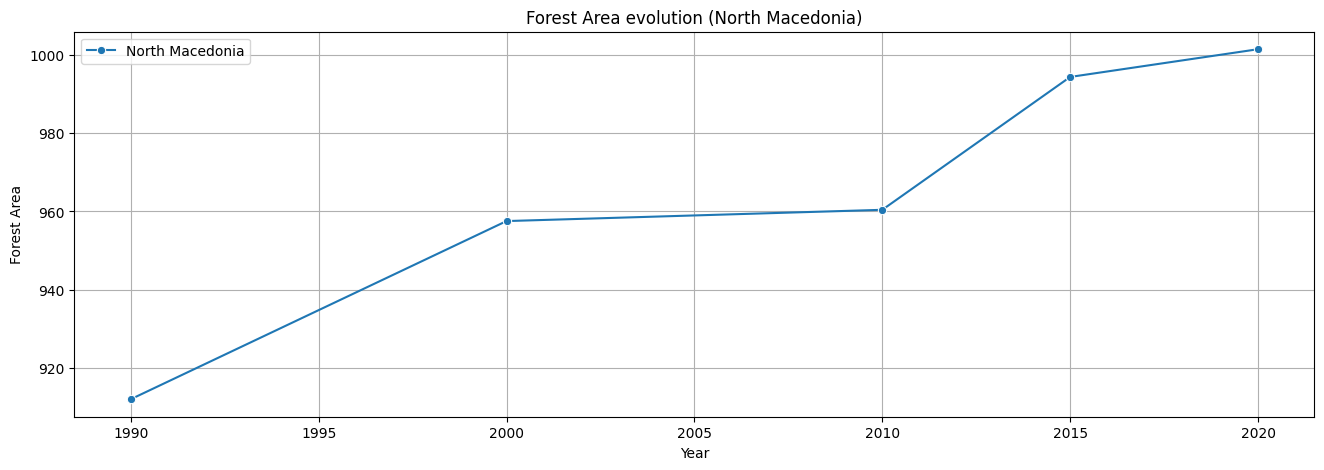

In [70]:
pais = "North Macedonia"
years = [f"Forest Area, {year}" for year in [1990, 2000, 2010, 2015, 2020]]
forest_area = (
    forest_df.filter(forest_df["Country and Area"] == pais).select(years).row(0)
)

years_np = [int(str(year).split(", ")[1]) for year in years]
forest_area_np = list(forest_area)

plt.figure(figsize=(16, 5))
sns.lineplot(x=years_np, y=forest_area_np, marker="o", label=pais)
plt.title(f"Forest Area evolution ({pais})")
plt.xlabel("Year")
plt.ylabel("Forest Area")
plt.grid(True)
plt.show()

To complete the missing forest area data for the year 2023, the following methodology was applied:

- **Eswatini:** Due to the linear trend observed in its historical data, a linear regression approach was chosen to predict the forest area for 2023. The trend is diagonally increasing, meaning that the forest area grows steadily over time.

- **North Macedonia:** Due to the linear trend observed in its historical data, a polynomial regression approach was chosen to predict the forest area for 2023.

- **South Sudan:** This country present a constant trend in their data, so it was decided to use the value recorded for the year 2020 as an estimate for 2023.

- **Monaco and Nauru:** These countries do not have forest area, so they were assigned a value of zero.

Initially, an alternative dataset was explored that covered a longer range of years and provided the anual percentage of forest area up since 1990 to 2021. This dataset offered a more complete view of the evolution of the forest area. However, the lack of information on the source and methodology of data collection raised doubts about its veracity, especially in the case of Eswatini, whose trend was perfectly linear increasing, which suggested the possibility of synthetic data.

Source: https://www.kaggle.com/datasets/webdevbadger/world-forest-area

After further investigation, it was confirmed that the data were real, since the results obtained by linear regression and projection with the original dataset have been similar. The equation used for the projection is as follows:

$$ \text{Average change rate} = \frac{FA_{2021} - FA_{1990}}{2021 - 1990} $$

$$ FA_{2023} = FA_{2021} \times (1 + \text{Average change rate})^2 $$

where:

* FA2021: represents the forest area in 2021.

* FA1990: represents the forest area in 1990.

In [71]:
missing_countries = ["Eswatini", "North Macedonia", "South Sudan"]
forest_df = forest_df.filter(pl.col("Country and Area").is_in(missing_countries))

forest_df_melted = forest_df.melt(
    id_vars=["Country and Area", "Total Land Area, 2020"],
    value_vars=[
        "Forest Area, 1990",
        "Forest Area, 2000",
        "Forest Area, 2010",
        "Forest Area, 2015",
        "Forest Area, 2020",
    ],
    variable_name="Year",
    value_name="Forest_Area",
).with_columns(pl.col("Year").str.extract(r"(\d+)").cast(pl.Int64).alias("Year"))

predicciones = {}

for country in missing_countries:
    data_pais = forest_df_melted.filter(pl.col("Country and Area") == country).sort(
        "Year"
    )

    X = data_pais["Year"].to_numpy().reshape(-1, 1)
    y = data_pais["Forest_Area"].to_numpy()

    if country == "North Macedonia":
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X)

        modelo = LinearRegression()
        modelo.fit(X_poly, y)

        X_pred = poly_features.transform(np.array([[2023]]))
        pred_2023 = modelo.predict(X_pred)[0]

    elif country == "Eswatini":
        modelo = LinearRegression()
        modelo.fit(X, y)
        pred_2023 = modelo.predict(np.array([[2023]]))[0]
    else:
        pred_2023 = y[-1]

    total_land_area = data_pais["Total Land Area, 2020"][0]
    forest_area_pct_2023 = (pred_2023 / total_land_area) * 100
    predicciones[country] = forest_area_pct_2023

world_df = world_df.with_columns(pl.col("Country").cast(pl.Utf8))

for country, pred in predicciones.items():
    world_df = world_df.with_columns(
        pl.when(pl.col("Country") == country)
        .then(pl.lit(pred).cast(pl.Float64))
        .otherwise(pl.col("Forested Area (%)"))
        .alias("Forested Area (%)")
    )

In [72]:
for country in ["Monaco", "Nauru"]:
    world_df = world_df.with_columns(
        pl.when(pl.col("Country") == country)
        .then(pl.lit(0.0).cast(pl.Float64))
        .otherwise(pl.col("Forested Area (%)"))
        .alias("Forested Area (%)")
    )

In [73]:
world_df.filter(
    pl.col("Country").is_in(
        ["Eswatini", "North Macedonia", "South Sudan", "Monaco", "Nauru"]
    )
).select(["Country", "Forested Area (%)"])

Country,Forested Area (%)
str,f64
"""Eswatini""",29.14006
"""Monaco""",0.0
"""Nauru""",0.0
"""North Macedonia""",39.948356
"""South Sudan""",11.329207


In [74]:
missing_values = world_df.select(
    [
        pl.col(col).is_null().sum().alias(f"{col} missing values")
        for col in world_df.select(["Country", "Forested Area (%)"]).columns
    ]
)
missing_values

Country missing values,Forested Area (%) missing values
u32,u32
0,0


We export the data:

In [75]:
world_df.select(["Country", "Forested Area (%)"]).write_csv(
    "../data/cleaned/forest_exported.csv"
)

Once the operations necessary to analyze the data have been carried out, we will try to answer the following questions:

> **Question 1:** Is a higher percentage of forest cover associated with lower Co2 emissions?

> **Question 2:** Do countries with greater forest cover tend to have a higher life expectancy?

### Correlation Matrix

A correlation matrix offers visual insights into the relationships between attributes, helping us answer the research questions. We prepare the data for correlation analysis by removing unnecessary columns and categorizing the remaining ones. This allows us to visually explore the relationships between attributes and answer the research questions.

In [76]:
world_df_cp = world_df.clone()
world_df_cp = world_df_cp.drop(["Country", "Abbreviation", "Latitude", "Longitude"])
world_df_cp = world_df_cp.drop_nulls()
world_df_cp

Co2-Emissions,Forested Area (%),GDP,Life expectancy
f64,f64,f64,f64
8672.0,2.1,1.9101e10,64.5
4536.0,28.1,1.5278e10,78.5
150006.0,0.8,1.6999e11,76.7
469.0,34.0,3.1541e9,84.04
34693.0,46.3,9.4635e10,60.8
…,…,…,…
164175.0,52.7,4.8236e11,72.1
192668.0,48.1,2.6192e11,75.3
10609.0,1.0,2.6914e10,66.1


We categorize attributes using the 33rd and 66th percentiles to segment data into 'Low', 'Regular', and 'High' tiers. This segmentation aims to enhance the clarity and interpretability of relationships within the correlation matrix, allowing for a more nuanced analysis of variable interactions.

In [77]:
fa_33, fa_66 = (
    world_df_cp["Forested Area (%)"].quantile(0.33),
    world_df_cp["Forested Area (%)"].quantile(0.66),
)
co2_33, co2_66 = (
    world_df_cp["Co2-Emissions"].quantile(0.33),
    world_df_cp["Co2-Emissions"].quantile(0.66),
)
gdp_33, gdp_66 = (
    world_df_cp["GDP"].quantile(0.33),
    world_df_cp["GDP"].quantile(0.66),
)
fe_33, fe_66 = (
    world_df_cp["Life expectancy"].quantile(0.33),
    world_df_cp["Life expectancy"].quantile(0.66),
)

world_df_cp = world_df_cp.with_columns(
    [
        pl.col("Forested Area (%)")
        .map_elements(
            lambda x: "Low" if x <= fa_33 else "Regular" if x <= fa_66 else "High",
            return_dtype=pl.Utf8,
        )
        .alias("Forest_area"),
        pl.col("Co2-Emissions")
        .map_elements(
            lambda x: "Low" if x <= co2_33 else "Regular" if x <= co2_66 else "High",
            return_dtype=pl.Utf8,
        )
        .alias("Co2"),
        pl.col("GDP")
        .map_elements(
            lambda x: "Low" if x <= gdp_33 else "Regular" if x <= gdp_66 else "High",
            return_dtype=pl.Utf8,
        )
        .alias("GDP_"),
        pl.col("Life expectancy")
        .map_elements(
            lambda x: "Low" if x <= fe_33 else "Regular" if x <= fe_66 else "High",
            return_dtype=pl.Utf8,
        )
        .alias("Life_expec"),
    ]
)

world_df_cp = world_df_cp.to_dummies(
    columns=["Forest_area", "Co2", "GDP_", "Life_expec"]
)

world_df_cp = world_df_cp.drop("Forested Area (%)")
world_df_cp = world_df_cp.drop("Co2-Emissions")
world_df_cp = world_df_cp.drop("GDP")
world_df_cp = world_df_cp.drop("Life expectancy")

world_df_cp.head(10)

Forest_area_High,Forest_area_Low,Forest_area_Regular,Co2_High,Co2_Low,Co2_Regular,GDP__High,GDP__Low,GDP__Regular,Life_expec_High,Life_expec_Low,Life_expec_Regular
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,1,0,0,0,1,0,0,1,0,1,0
0,0,1,0,1,0,0,0,1,1,0,0
0,1,0,1,0,0,1,0,0,1,0,0
0,0,1,0,1,0,0,1,0,1,0,0
1,0,0,0,0,1,1,0,0,0,1,0
0,0,1,0,1,0,0,1,0,1,0,0
0,1,0,1,0,0,1,0,0,0,0,1
0,1,0,0,0,1,0,1,0,0,0,1
0,0,1,1,0,0,1,0,0,1,0,0


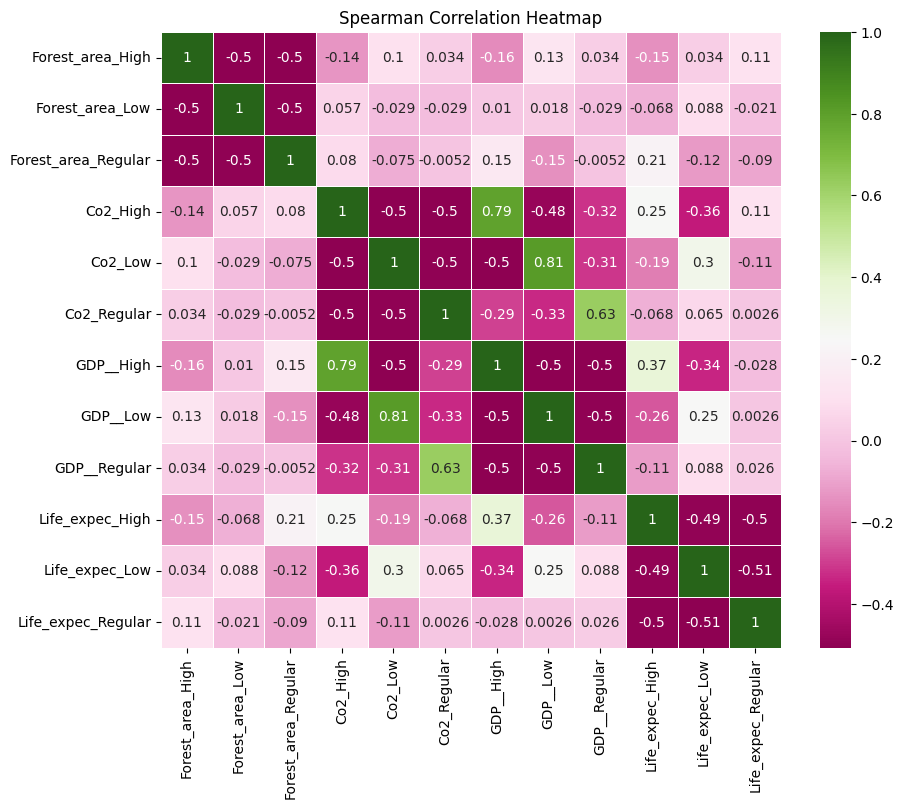

In [78]:
correlation_matrix_pearson = world_df_cp.to_pandas().corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap="PiYG", linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

The correlation analysis, using Pearson, Spearman, and Kendall methods, did not revealed statistically significant relationships between the variables. This absence of correlation was corroborated by the scatter plot, which showed no discernible patterns.  The unchanging nature of the correlation matrix is likely a consequence of the small sample size (under 200 data examples), which may limit the power to detect true correlations.

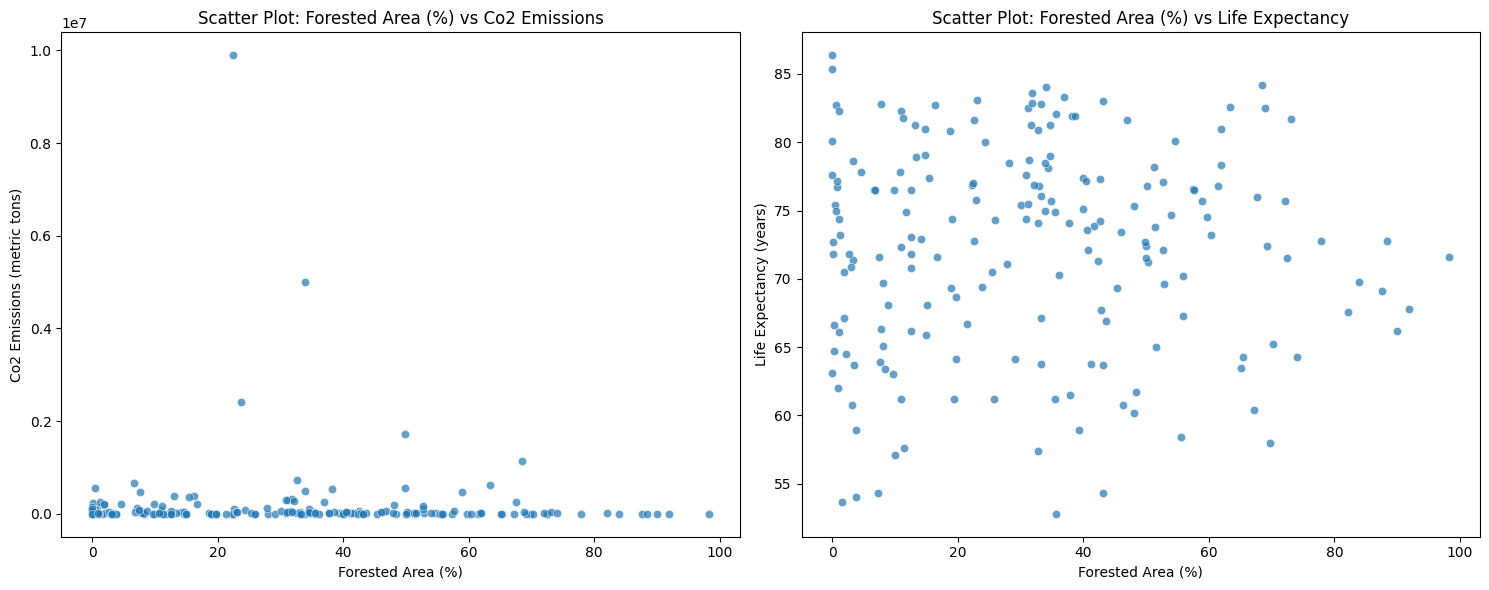

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(
    data=world_df, x="Forested Area (%)", y="Co2-Emissions", alpha=0.7, ax=axes[0]
)
axes[0].set_xlabel("Forested Area (%)")
axes[0].set_ylabel("Co2 Emissions (metric tons)")
axes[0].set_title("Scatter Plot: Forested Area (%) vs Co2 Emissions")

sns.scatterplot(
    data=world_df, x="Forested Area (%)", y="Life expectancy", alpha=0.7, ax=axes[1]
)
axes[1].set_xlabel("Forested Area (%)")
axes[1].set_ylabel("Life Expectancy (years)")
axes[1].set_title("Scatter Plot: Forested Area (%) vs Life Expectancy")

plt.tight_layout()
plt.show()

### **Final deductions**
1. Countries exhibiting high Co2 emissions tend to have a lower percentage of forest cover. This phenomenon may be attributed to a reduced degree of industrialization or the implementation of more stringent environmental policies. However, there does not appear to be a clear relationship between the volume of Co2 emissions and the percentage of forest area. 

2. Surprisingly, the correlation suggests that high forest area is not strongly associated with longer life expectancy. In fact, the relationship with high life expectancy is slightly negative (-0.13). This may indicate that countries with more forests may not necessarily be the most developed in terms of health and well-being.

3. Finally, and although unrelated to the questions, it is worth noting that countries with high GDP tend to have high Co2 emissions, suggesting that economic development is linked to energy consumption and industrial activity. As GDP increases, it is less common to find low Co2 emissions, reinforcing the idea that larger economies have a larger carbon footprint. This may indicate that some countries with low GDP still rely on polluting energy sources, such as coal, to sustain their economy.

  This information will be essential for the subsequent analysis to be carried out.

<hr>

## **Co2 EMISSIONS ANALYSIS**

Since the dataset has missing values in Co2-Emissions column, and some of these values **​​appear to be incorrect**, let's load another dataset from the following source.

Co2 emissions of all world countries, 2022 Report: https://edgar.jrc.ec.europa.eu/report_2022

Authors: Crippa M., Guizzardi D., Banja M., Solazzo E., Muntean M., Schaaf E., Pagani F., Monforti-Ferrario F., Olivier, J.G.J., Quadrelli, R., Grassi, G., Rossi, S., Oom, D., Branco, A., San-Miguel, J., Vignati, E. Co2

In [80]:
co2_df_original: pl.DataFrame = pl.read_excel(
    "../data/raw/ambiental_analysis/EDGARv7.0_FT2021_fossil_CO2_booklet_2022.xlsx",
    sheet_name="fossil_CO2_totals_by_country",
)

# Let's remove the previously used columns, which are no longer useful for this analysis
world_df = world_df.drop(["Forested Area (%)", "Life expectancy"])

co2_df = co2_df_original.clone()

In [81]:
world_df

Country,Abbreviation,Co2-Emissions,GDP,Latitude,Longitude
str,str,f64,f64,f64,f64
"""Afghanistan""","""AF""",8672.0,1.9101e10,33.93911,67.709953
"""Albania""","""AL""",4536.0,1.5278e10,41.153332,20.168331
"""Algeria""","""DZ""",150006.0,1.6999e11,28.033886,1.659626
"""Andorra""","""AD""",469.0,3.1541e9,42.506285,1.521801
"""Angola""","""AO""",34693.0,9.4635e10,-11.202692,17.873887
…,…,…,…,…,…
"""Venezuela""","""VE""",164175.0,4.8236e11,6.42375,-66.58973
"""Vietnam""","""VN""",192668.0,2.6192e11,14.058324,108.277199
"""Yemen""","""YE""",10609.0,2.6914e10,15.552727,48.516388


Now, we have to answer the following question: Which countries in the new dataset are not in the original dataset and vice versa?

In [82]:
print(list(world_df.filter(~world_df["Country"].is_in(co2_df["Country"]))["Country"]))
print(list(co2_df.filter(~co2_df["Country"].is_in(world_df["Country"]))["Country"]))

['Andorra', 'The Bahamas', 'Ivory Coast', 'Cape Verde', 'Republic of the Congo', 'Czech Republic', 'France', 'Republic of Ireland', 'Israel', 'Italy', 'Liechtenstein', 'Marshall Islands', 'Federated States of Micronesia', 'Monaco', 'Montenegro', 'Myanmar', 'Nauru', 'San Marino', 'Sao Tome and Principe', 'Serbia', 'South Sudan', 'Spain', 'Sudan', 'Switzerland', 'East Timor', 'Tuvalu']
['Aruba', 'Anguilla', 'International Aviation', 'Curaçao', 'Bahamas', 'Bermuda', 'Switzerland and Liechtenstein', 'Côte d’Ivoire', 'Congo', 'Cook Islands', 'Cabo Verde', 'Cayman Islands', 'Czechia', 'Western Sahara', 'Spain and Andorra', 'Falkland Islands', 'France and Monaco', 'Faroes', 'Gibraltar', 'Guadeloupe', 'Greenland', 'French Guiana', 'Hong Kong', 'Ireland', 'Israel and Palestine, State of', 'Italy, San Marino and the Holy See', 'Macao', 'Myanmar/Burma', 'Martinique', 'New Caledonia', 'Puerto Rico', 'French Polynesia', 'Réunion', 'Serbia and Montenegro', 'Sudan and South Sudan', 'International Shi

We standardize country names by applying a series of replacements to ensure consistency (e.g. 'Côte d'Ivoire' becomes 'Ivory Coast', 'Spain and Andorra' become two rows). Furthermore, it is necessary to make the proportions in these cases, since 'Spain and Andorra' indicates the emissions of both countries together.

In [83]:
co2_df = co2_df.with_columns(
    pl.col("Country")
    .str.strip_chars()
    .replace(
        {
            # "Spain and Andorra": "Andorra",
            "Bahamas": "The Bahamas",
            "Côte d’Ivoire": "Ivory Coast",
            "Cabo Verde": "Cape Verde",
            "Congo": "Republic of the Congo",
            "Czechia": "Czech Republic",
            "France and Monaco": "France",
            "Ireland": "Republic of Ireland",
            "Israel and Palestine, State of": "Israel",
            "Italy, San Marino and the Holy See": "Italy",
            # "Switzerland and Liechtenstein" : "Liechtenstein",
            # "France and Monaco" : "Monaco",
            # "Serbia and Montenegro" : "Montenegro",
            "Myanmar/Burma": "Myanmar",
            # "Italy, San Marino and the Holy See" : "San Marino",
            "São Tomé and Príncipe": "Sao Tome and Principe",
            "Serbia and Montenegro": "Serbia",
            # "Sudan and South Sudan" : "South Sudan",
            "Spain and Andorra": "Spain",
            "Sudan and South Sudan": "Sudan",
            "Switzerland and Liechtenstein": "Switzerland",
            "Timor-Leste": "East Timor",
        }
    )
    .alias("Country")
)

# Proportion system provided by ChatGPT
proportions = {
    "Andorra": ("Spain", 0.0017),
    "Liechtenstein": ("Switzerland", 0.0009),
    "Monaco": ("France", 0.0007),
    "Montenegro": ("Serbia", 0.012),
    "San Marino": ("Italy", 0.0005),
    "South Sudan": ("Sudan", 0.075),
}

numeric_cols = co2_df.select(pl.col(pl.Float64)).columns

new_rows = []
for new_country, (source_country, proportion) in proportions.items():
    if source_country in co2_df["Country"].to_list():
        source_row = co2_df.filter(pl.col("Country") == source_country)

        new_row = source_row.with_columns(
            pl.lit(new_country).alias("Country"),
            *[pl.col(col) * proportion for col in numeric_cols],
        )

        co2_df = co2_df.with_columns(
            *[
                pl.when(pl.col("Country") == source_country)
                .then(pl.col(col) * (1 - proportion))
                .otherwise(pl.col(col))
                .alias(col)
                for col in numeric_cols
            ]
        )

        new_rows.append(new_row)

if new_rows:
    co2_df = pl.concat([co2_df, *new_rows])

co2_df

Substance,EDGAR Country Code,Country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CO2""","""ABW""","""Aruba""",0.081876,0.081889,0.095415,0.09963,0.089089,0.105139,0.096041,0.105305,0.106662,0.10083,0.102091,0.103576,0.09435,0.098185,0.11477,0.112121,0.110246,0.114517,0.422667,0.517171,0.524847,0.620443,0.720163,0.691391,0.757696,0.814652,0.54444,0.831664,0.832856,0.879121,0.943343,0.969338,0.987977,1.280156,1.329434,1.368961,1.33068,1.36139,1.280767,1.379072,1.332395,1.266665,1.618441,1.588689,1.615728,1.607879,1.578644,1.315458,1.347594,1.387156,1.144333,1.274134
"""CO2""","""AFG""","""Afghanistan""",1.739541,1.737823,1.715749,1.742813,2.198551,2.037627,1.899895,2.288853,1.940763,2.066211,2.016268,2.269086,2.31919,3.010081,3.229588,4.128133,3.950682,3.274469,3.098431,2.906892,2.910442,2.77889,1.696297,1.626566,1.555483,1.380338,1.353128,1.337146,1.347632,1.305541,1.079641,0.993244,0.985184,1.068472,0.957256,1.31614,1.471212,2.046648,4.068388,6.66594,8.086217,11.918898,10.238064,8.484183,8.01629,8.361849,7.635914,8.145255,9.106997,8.082724,8.183718,8.347669
"""CO2""","""AGO""","""Angola""",8.95257,8.538308,10.388519,11.372301,11.833761,10.930423,7.317385,12.057774,14.239234,14.204373,14.342032,13.255768,12.795299,13.251282,13.38997,14.140745,14.289491,14.55459,15.005273,15.168202,11.298197,11.851036,12.196366,12.213651,11.568319,13.039689,15.773126,16.50058,17.138055,18.134385,16.614837,16.294516,16.036635,17.450208,17.815945,15.976263,16.734873,17.247142,19.501033,21.322357,22.973758,23.864636,24.186843,27.822325,30.407844,32.59413,30.69166,26.129882,24.048619,25.325994,23.055844,24.450057
"""CO2""","""AIA""","""Anguilla""",0.002168,0.002168,0.002264,0.002109,0.00235,0.002584,0.002434,0.002537,0.002902,0.003213,0.004413,0.00664,0.007019,0.006089,0.005801,0.003671,0.003155,0.006126,0.005797,0.006148,0.006114,0.007579,0.007903,0.009952,0.013131,0.016396,0.016213,0.013564,0.012449,0.011751,0.015532,0.015911,0.010859,0.014108,0.013472,0.013662,0.012812,0.012355,0.015268,0.020161,0.024004,0.026008,0.026023,0.027941,0.027896,0.028005,0.02834,0.029062,0.028223,0.02758,0.022779,0.025409
"""CO2""","""AIR""","""International Aviation""",169.300997,169.300997,179.147487,186.892096,179.793331,173.86602,174.273791,190.068978,197.222628,203.975128,202.807889,202.067993,209.348468,211.18745,219.125397,225.156168,247.390953,261.563743,276.366713,290.296645,258.993781,251.900903,260.067858,265.022085,278.58357,289.103425,300.847663,315.607704,326.243076,340.142087,352.628829,346.128098,366.703238,364.670144,393.90464,418.83879,434.148654,448.063493,455.899982,434.205492,458.205042,472.112408,472.721119,480.909126,496.627697,524.654035,548.207777,582.23049,609.630469,617.763229,338.144083,390.16625
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""CO2""","""CHE""","""Liechtenstein""",0.037526,0.039245,0.039946,0.043043,0.03872,0.036449,0.038002,0.038416,0.039462,0.038282,0.038968,0.03684,0.034856,0.038544,0.038096,0.040982,0.040906,0.039497,0.039549,0.03939,0.040466,0.042555,0.042501,0.040405,0.039558,0.040276,0.040767,0.039615,0.040931,0.041169,0.040437,0.041727,0.040257,0.041429,0.041913,0.042468,0.042074,0.04032,0.041559,0.040313,0.041833,0.038164,0.039338,0.040258,0.037118,0.036324,0.036814,0.035939,0.034829,0.034719,0.030804,0.031565
"""CO2""","""FRA""","""Monaco""",0.327233,0.336088,0.348405,0.373865,0.361814,0.333951,0.363842,0.352005,0.363883,0.369341,0.355268,0.319951,0.304555,0.291832,0.283813,0.276298,0.267846,0.263252,0.263177,0.273831,0.2

Now, we will check that some countries from the world information dataset (world_df) do not yet appear in the Co2 emissions dataset, after having mapped the names

In [84]:
mssing_countries = world_df.filter(~world_df["Country"].is_in(co2_df["Country"]))
mssing_countries["Country"]

Country
str
"""Marshall Islands"""
"""Federated States of Micronesia"""
"""Nauru"""
"""Tuvalu"""


To ensure data consistency, we perform a join-like operation, retaining only the countries present in both datasets. Our primary analysis focuses on Co2 emissions data from odd years between 1999 and 2021. This selection is deliberate, as data from 2020 may reflect the global impact of the COVID-19 pandemic, which could introduce noise or bias into our trend analysis. However, to specifically investigate these potential pandemic-related effects, we will also conduct a separate analysis using 2020 data. 
Subsequently, we select the relevant columns and discard the rest. Finally, both DataFrames are sorted alphabetically by country to ensure consistency.

In [85]:
world_df = world_df.filter(world_df["Country"].is_in(co2_df["Country"]))
co2_df = co2_df.filter(co2_df["Country"].is_in(world_df["Country"]))

columns_to_keep = {"Country"} | {"2020"} | {str(year) for year in range(1999, 2022, 2)}
co2_df = co2_df.drop([col for col in co2_df.columns if col not in columns_to_keep])

world_df = world_df.sort("Country")
co2_df = co2_df.sort("Country")
co2_df

Country,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2020,2021
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Afghanistan""",1.305541,0.993244,1.068472,1.31614,2.046648,6.66594,11.918898,8.484183,8.361849,8.145255,8.082724,8.183718,8.347669
"""Albania""",3.129668,3.482386,4.24599,4.213394,4.283612,4.334349,5.014836,4.811345,4.916119,5.346925,5.038618,4.70692,4.591114
"""Algeria""",81.046152,82.135387,93.084824,98.608717,106.029906,114.27572,122.971141,141.718781,161.483109,162.801875,177.923437,168.949946,173.000651
"""Andorra""",0.506579,0.535002,0.579033,0.631613,0.639156,0.517473,0.498449,0.442604,0.465314,0.477435,0.436569,0.361194,0.394254
"""Angola""",18.134385,16.294516,17.450208,15.976263,17.247142,21.322357,23.864636,27.822325,32.59413,26.129882,25.325994,23.055844,24.450057
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Venezuela""",131.816051,143.174239,143.154681,156.192207,152.421838,162.151494,169.631421,190.77808,172.616465,148.488894,118.791433,100.156836,104.672459
"""Vietnam""",51.080936,62.102483,77.646326,100.432016,114.043045,140.541178,157.192691,164.319918,221.188419,231.260718,333.50806,322.017652,321.413338
"""Yemen""",14.720941,16.73918,19.502603,21.989487,24.298408,27.615073,22.97968,28.76669,14.247711,10.695935,12.307957,11.607959,12.047245


As a final preprocessing step, we validate the integrity of the Co2 emissions dataset (co2_df) by checking for missing data. We generate a summary table that shows the number of missing values present in each column. 

In [86]:
missing_values = co2_df.select(
    [
        pl.col(col).is_null().sum().alias(f"{col} missing values")
        for col in co2_df.columns
    ]
)
missing_values

Country missing values,1999 missing values,2001 missing values,2003 missing values,2005 missing values,2007 missing values,2009 missing values,2011 missing values,2013 missing values,2015 missing values,2017 missing values,2019 missing values,2020 missing values,2021 missing values
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0


<hr>

As previously noted, the global information dataset had missing and incorrect values ​​for the Co2_Emissions column. To mitigate these issues, we will analyze historical Co2 emission trends for each country during odd years between 1999 and 2021, which will ultimately allow us to predict 2023 emissions. This leads us to the **first question of the Co2 analysis**:

> Is there a proximity relationship between country's Co2 emissions compared to its neighbouring countries? If so, incorporating geographic coordinates (latitude and longitude) will be crucial for accurate emissions prediction.

To investigate this, we will use the country emissions record for the year 2021, which is the most recent one we have available.

In [87]:
co2_df_folium = co2_df.clone()

co2_df_folium = co2_df_folium.with_columns(
    world_df["Abbreviation"], world_df["Latitude"], world_df["Longitude"]
)
co2_df_folium

Country,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2020,2021,Abbreviation,Latitude,Longitude
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64
"""Afghanistan""",1.305541,0.993244,1.068472,1.31614,2.046648,6.66594,11.918898,8.484183,8.361849,8.145255,8.082724,8.183718,8.347669,"""AF""",33.93911,67.709953
"""Albania""",3.129668,3.482386,4.24599,4.213394,4.283612,4.334349,5.014836,4.811345,4.916119,5.346925,5.038618,4.70692,4.591114,"""AL""",41.153332,20.168331
"""Algeria""",81.046152,82.135387,93.084824,98.608717,106.029906,114.27572,122.971141,141.718781,161.483109,162.801875,177.923437,168.949946,173.000651,"""DZ""",28.033886,1.659626
"""Andorra""",0.506579,0.535002,0.579033,0.631613,0.639156,0.517473,0.498449,0.442604,0.465314,0.477435,0.436569,0.361194,0.394254,"""AD""",42.506285,1.521801
"""Angola""",18.134385,16.294516,17.450208,15.976263,17.247142,21.322357,23.864636,27.822325,32.59413,26.129882,25.325994,23.055844,24.450057,"""AO""",-11.202692,17.873887
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Venezuela""",131.816051,143.174239,143.154681,156.192207,152.421838,162.151494,169.631421,190.77808,172.616465,148.488894,118.791433,100.156836,104.672459,"""VE""",6.42375,-66.58973
"""Vietnam""",51.080936,62.102483,77.646326,100.432016,114.043045,140.541178,157.192691,164.319918,221.188419,231.260718,333.50806,322.017652,321.413338,"""VN""",14.058324,108.277199
"""Yemen""",14.720941,16.73918,19.502603,21.989487,24.298408,27.615073,22.97968,28.76669,14.247711,10.695935,12.307957,11.607959,12.047245,"""YE""",15.552727,48.516388


We can create an interactive map using Folium library, where the size and color of markers indicate the amount of emissions per country

In [88]:
# Functions generated with ChatGPT to calculate marker radius and grayscale gradient color
def scale_radius(value, min_val, max_val, min_radius=1, max_radius=30):
    return min_radius + (np.log1p(value) - np.log1p(min_val)) / (
        np.log1p(max_val) - np.log1p(min_val)
    ) * (max_radius - min_radius)


def get_gray_shade(value):
    if value <= 100:
        gray_value = 180
    elif value >= 1000:
        gray_value = 30
    else:
        gray_value = int(140 - (value / 1000) * 170)
    return f"rgb({gray_value},{gray_value},{gray_value})"

In [89]:
df_selected = co2_df_folium.select(
    ["Country", "Abbreviation", "Latitude", "Longitude", "2021"]
).drop_nulls()
min_emission, max_emission = df_selected["2021"].min(), df_selected["2021"].max()

co2_map = folium.Map(location=(30, 10), zoom_start=4, tiles="cartodbpositron")

for row in df_selected.iter_rows(named=True):
    radius = scale_radius(row["2021"], min_emission, max_emission)
    gray_color = get_gray_shade(row["2021"])
    folium.CircleMarker(
        location=(row["Latitude"], row["Longitude"]),
        radius=radius,
        color=gray_color,
        fill=True,
        fill_color=gray_color,
        fill_opacity=0.6,
        popup=f"{row['Country']} ({row['Abbreviation']}): {row['2021']:,.4f} toneladas",
    ).add_to(co2_map)

co2_map

As we can see, proximity is not a relevant factor in a country's Co2 emissions. While Spain and France, for example, are geographically close, their emission levels are substantially higher than those of Portugal and Switzerland, which are also nearby.

Taking this into account, we are going to visualize the evolution of Co2 for some countries, to later calculate a prediction by applying a regression model.

In [90]:
df_top10 = (
    co2_df.slice(9, 1)
    .vstack(co2_df.slice(12, 1))
    .vstack(co2_df.slice(15, 1))
    .vstack(co2_df.slice(18, 1))
    .melt(
        id_vars=["Country"],
        value_vars=[str(year) for year in range(1999, 2022, 2)],
        variable_name="Year",
        value_name="Emissions",
    )
)

line = px.line(
    df_top10.to_pandas(), x="Year", y="Emissions", color="Country", markers=True
)
line.update_yaxes(
    title_text="Co2 emissions (metric tons per capita)",
    range=[0, df_top10["Emissions"].max() * 1.1],
)
line.update_yaxes(title_text="Co2 emissions (metric tons)")
line.update_xaxes(title_text="Year", rangeslider_visible=False)
line.update_layout(
    legend=dict(title="Country"),
    showlegend=True,
    title={
        "text": "Co2 Emissions Evolution",
        "y": 0.94,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    template="plotly_white",
)
line.show()

<hr>

### Co2 Predictions (2023)

Our approach to predicting 2023 Co2 emissions involves building country-specific polynomial regression models with Ridge or Lasso regularization. We begin by extracting and scaling historical emission data for each country in the co2_df DataFrame. We then employ cross-validation to determine the optimal polynomial degree and regularization strength for each model. Finally, we train the selected model, predict 2023 emissions, inverse-scale the predictions, and store them in a Polars DataFrame. This methodology allows us to account for individual country emission patterns, since we have verified that there is no relationship between emissions by proximity.

In [91]:
year_columns = [
    col
    for col in co2_df.columns
    if col not in ["Country", "Abbreviation", "Latitude", "Longitude", "2020"]
]
years = np.array([int(y) for y in year_columns]).reshape(-1, 1)
predictions = []

for row in co2_df.iter_rows(named=True):
    country = row["Country"]
    emissions = np.array([row[year] for year in year_columns]).reshape(-1, 1)

    year_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)

    emission_scaler = StandardScaler()
    emissions_scaled = emission_scaler.fit_transform(emissions)

    best_degree = 1
    best_alpha = 0.001
    best_score = -np.inf
    best_model_type = "Ridge"

    for degree in [1, 2, 3]:
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(years_scaled)

        for alpha in [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]:
            for model_type in ["Ridge", "Lasso"]:
                model = (
                    Ridge(alpha=alpha) if model_type == "Ridge" else Lasso(alpha=alpha)
                )

                scores = cross_val_score(
                    model,
                    X_poly,
                    emissions_scaled,
                    cv=10,
                    scoring="neg_mean_absolute_error",
                )
                avg_score = np.mean(scores)

                if avg_score > best_score:
                    best_score = avg_score
                    best_degree = degree
                    best_alpha = alpha
                    best_model_type = model_type

    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(years_scaled)

    model = (
        Ridge(alpha=best_alpha)
        if best_model_type == "Ridge"
        else Lasso(alpha=best_alpha)
    )
    model.fit(X_poly, emissions_scaled)

    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(years_scaled)

    model = Ridge(alpha=best_alpha)
    model.fit(X_poly, emissions_scaled)

    X_pred = year_scaler.transform([[2023]])
    X_pred_poly = poly.transform(X_pred)
    predicted_emission_scaled = model.predict(X_pred_poly)[0][0]

    predicted_emission = emission_scaler.inverse_transform(
        [[predicted_emission_scaled]]
    )[0][0]
    predictions.append({"Country": country, "Co2-Emissions": predicted_emission})

predictions_df = pl.DataFrame(predictions)
predictions_df.filter(pl.arange(0, predictions_df.height).is_in([9, 12, 15, 18]))

Country,Co2-Emissions
str,f64
"""Austria""",67.275399
"""Bangladesh""",122.82605
"""Belgium""",94.898663
"""Bhutan""",2.234046


In [92]:
world_df = world_df.with_columns(predictions_df["Co2-Emissions"])
world_df

Country,Abbreviation,Co2-Emissions,GDP,Latitude,Longitude
str,str,f64,f64,f64,f64
"""Afghanistan""","""AF""",8.399265,1.9101e10,33.93911,67.709953
"""Albania""","""AL""",4.691466,1.5278e10,41.153332,20.168331
"""Algeria""","""DZ""",189.181028,1.6999e11,28.033886,1.659626
"""Andorra""","""AD""",0.413181,3.1541e9,42.506285,1.521801
"""Angola""","""AO""",21.629318,9.4635e10,-11.202692,17.873887
…,…,…,…,…,…
"""Venezuela""","""VE""",66.122815,4.8236e11,6.42375,-66.58973
"""Vietnam""","""VN""",380.38592,2.6192e11,14.058324,108.277199
"""Yemen""","""YE""",2.47828,2.6914e10,15.552727,48.516388


<hr>

### Correlation Matrix

The 01_introduction_and_processing.ipynb notebook reveals a strong positive correlation (0.92) between CO2 emissions and GDP.  To gain a more nuanced understanding of this relationship, we will construct a detailed correlation matrix, incorporating GDP and Co2-Emissions as categoricals variables.

In [93]:
world_df_cp = world_df.clone()

co2_33, co2_66 = (
    world_df["Co2-Emissions"].quantile(0.33),
    world_df["Co2-Emissions"].quantile(0.66),
)
gdp_33, gdp_66 = world_df["GDP"].quantile(0.33), world_df["GDP"].quantile(0.66)

world_df_cp = world_df.with_columns(
    [
        pl.col("Co2-Emissions")
        .map_elements(
            lambda x: "Low" if x <= co2_33 else "Medium" if x <= co2_66 else "High",
            return_dtype=pl.Utf8,
        )
        .alias("Co2_"),
        pl.col("GDP")
        .map_elements(
            lambda x: "Low" if x <= gdp_33 else "Medium" if x <= gdp_66 else "High",
            return_dtype=pl.Utf8,
        )
        .alias("GDP_"),
    ]
)

world_df_cp = world_df_cp.to_dummies(columns=["Co2_", "GDP_"])
world_df_cp = world_df_cp.drop(
    ["Country", "Abbreviation", "Latitude", "Longitude", "Co2-Emissions", "GDP"]
)
world_df_cp.head(10)

Co2__High,Co2__Low,Co2__Medium,GDP__High,GDP__Low,GDP__Medium
u8,u8,u8,u8,u8,u8
0,0,1,0,0,1
0,1,0,0,0,1
1,0,0,1,0,0
0,1,0,0,1,0
0,0,1,0,0,1
0,1,0,0,1,0
1,0,0,1,0,0
0,0,1,0,1,0
1,0,0,1,0,0


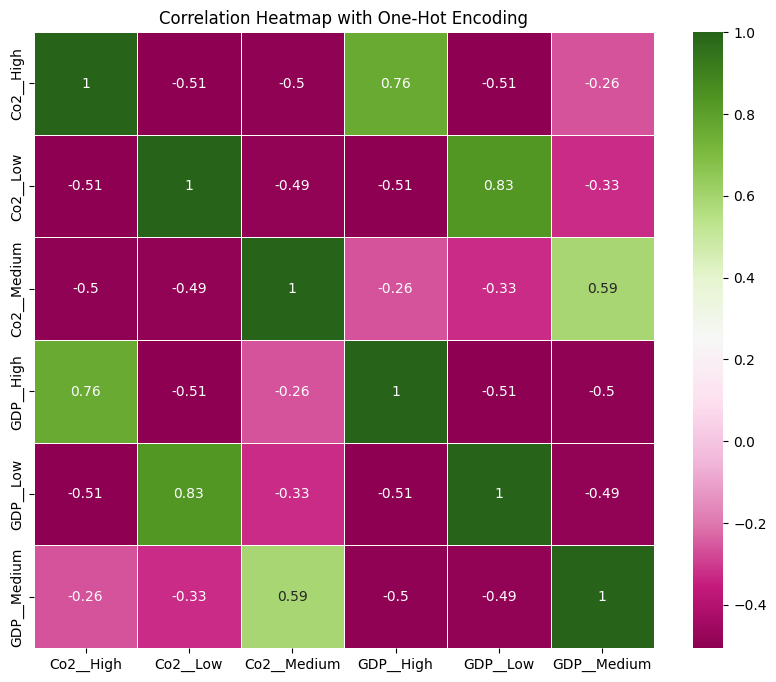

In [94]:
corr_matrix_pd = world_df_cp.corr().to_pandas()
corr_matrix_pd.index = world_df_cp.columns
corr_matrix_pd.columns = world_df_cp.columns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pd, annot=True, cmap="PiYG", linewidths=0.5)
plt.title("Correlation Heatmap with One-Hot Encoding")
plt.show()

Our next step is to identify potential outliers in the relationship between economic size and Co2 emissions, using our 2023 predictions. We are particularly interested in identifying any countries that deviate significantly from the expected correlation. 
Specifically, the **following research question** is:

> Are there countries whose Co2 emissions are significantly higher or lower, than expected given their economic size?

We will implement a linear regression and analyze the residuals because it is an effective strategy to detect anomalies in the relationship between GDP and Co2 emissions. Based on the correlation matrix, we identified a strong relationship between both variables, so by modeling them with regression we can establish an expected trend. Then, by examining the residuals (the difference between the observed and predicted values), we identify which countries deviate significantly from this trend. Those with high waste emit more Co2 than expected for their level of GDP, while those with negative waste emit less. Additionally, we use a logarithmic scale because both GDP and Co2 emissions vary by orders of magnitude. This allows us to facilitate model fitting and improve data interpretation, as well as allowing better detection of outliers by giving more visibility to countries with smaller values.

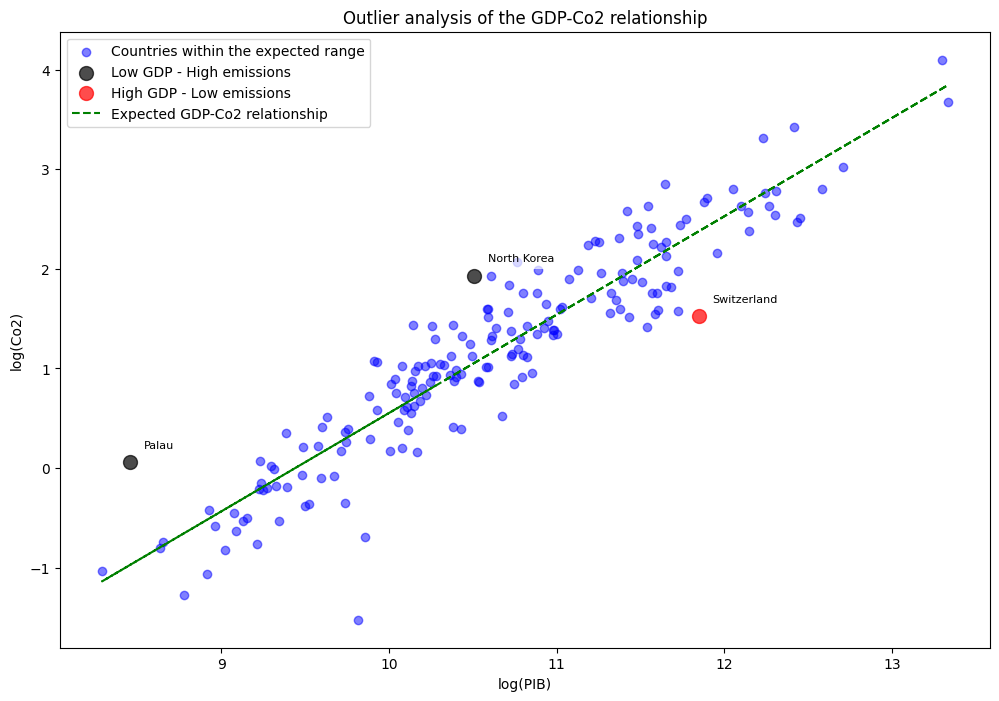

Country,Abbreviation,Co2-Emissions,GDP,Latitude,Longitude
str,str,f64,f64,f64,f64
"""North Korea""","""KP""",85.390887,3.2100e10,40.339852,127.510093
"""Palau""","""PW""",1.13966,2.839949e8,7.51498,134.58252
"""Switzerland""","""CH""",33.338926,7.0308e11,46.818188,8.227512


In [95]:
X = np.log10(world_df["GDP"].to_numpy()).reshape(-1, 1)
y = np.log10(world_df["Co2-Emissions"].to_numpy())
countries = world_df["Country"].to_numpy()

reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

residuals = y - y_pred
z_scores = stats.zscore(residuals)

threshold = 2.2
high_emissions_low_gdp = (z_scores > threshold) & (X.flatten() < X.mean())
low_emissions_high_gdp = (z_scores < -threshold) & (X.flatten() > X.mean())
outliers_mask = high_emissions_low_gdp | low_emissions_high_gdp

plt.figure(figsize=(12, 8))
plt.scatter(
    X[~outliers_mask],
    y[~outliers_mask],
    alpha=0.5,
    label="Countries within the expected range",
    color="blue",
)
plt.scatter(
    X[high_emissions_low_gdp],
    y[high_emissions_low_gdp],
    color="black",
    alpha=0.7,
    label="Low GDP - High emissions",
    s=100,
)
plt.scatter(
    X[low_emissions_high_gdp],
    y[low_emissions_high_gdp],
    color="red",
    alpha=0.7,
    label="High GDP - Low emissions",
    s=100,
)
plt.plot(
    X, y_pred, color="green", linestyle="--", label="Expected GDP-Co2 relationship"
)

for idx in np.where(outliers_mask)[0]:
    plt.annotate(
        countries[idx],
        (X[idx], y[idx]),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

plt.xlabel("log(PIB)")
plt.ylabel("log(Co2)")
plt.title("Outlier analysis of the GDP-Co2 relationship")
plt.legend()
plt.show()

outliers_df = world_df.filter(pl.Series(outliers_mask))
outliers_df

We confirmed the results obtained by applying clustering, such as DBSCAN:

In [96]:
X = np.log10(world_df[["GDP", "Co2-Emissions"]].to_numpy())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.75, min_samples=4)
clusters = dbscan.fit_predict(X_scaled)

non_outliers = clusters != -1
X_clean = X[non_outliers]

slope = np.polyfit(X_clean[:, 0], X_clean[:, 1], 1)[0]
expected_co2 = X[:, 0] * slope + np.median(X[:, 1] - X[:, 0] * slope)

residuals = X[:, 1] - expected_co2

std_residuals = np.std(residuals[non_outliers])
gdp_median = np.median(X[:, 0])

outlier_threshold = 2.2
high_emissions_low_gdp = (residuals > outlier_threshold * std_residuals) & (
    X[:, 0] < gdp_median
)
low_emissions_high_gdp = (residuals < -outlier_threshold * std_residuals) & (
    X[:, 0] > gdp_median
)

outliers_mask = high_emissions_low_gdp | low_emissions_high_gdp

outliers_df = world_df.filter(pl.Series(outliers_mask))

outlier_types = []
for idx in range(len(outliers_df)):
    mask_idx = np.where(outliers_mask)[0][idx]
    if high_emissions_low_gdp[mask_idx]:
        outlier_types.append("Low GDP - High emissions")
    else:
        outlier_types.append("High GDP - Low emissions")

outliers_df = outliers_df.with_columns(pl.Series("Outlier", outlier_types))

print("\nCountries detected as outliers:")
outliers_df


Countries detected as outliers:


Country,Abbreviation,Co2-Emissions,GDP,Latitude,Longitude,Outlier
str,str,f64,f64,f64,f64,str
"""North Korea""","""KP""",85.390887,3.2100e10,40.339852,127.510093,"""Low GDP - High emissions"""
"""Palau""","""PW""",1.13966,2.839949e8,7.51498,134.58252,"""Low GDP - High emissions"""
"""Switzerland""","""CH""",33.338926,7.0308e11,46.818188,8.227512,"""High GDP - Low emissions"""


To understand the complex interplay of factors influencing Co2 emissions, I leveraged ChatGPT to analyze country-specific data.  This helped me interpret the relationships between energy sources, economic activities, and emissions levels. This analysis provided crucial context for the visualization, allowing for a more nuanced understanding of the obtained result.

- **North Korea (Low GDP - High Emissions)**
North Korea has a low GDP but relatively high Co2 emissions. The country relies heavily on coal for energy production, as it lacks access to modern, cleaner energy sources. Its industrial sector is outdated, with inefficient factories and power plants that contribute significantly to emissions. Furthermore, despite economic struggles, North Korea maintains energy-intensive military and industrial projects, which push emissions higher than expected for its low economic output.

- **Switzerland (High GDP - Low Emissions)**
Switzerland has a high GDP but relatively low Co2 emissions. This can be explained by its energy sources and economic structure. The country relies heavily on hydropower and nuclear energy, significantly reducing its carbon footprint. Additionally, Switzerland has a strong services-based economy, particularly in finance and pharmaceuticals, which are not carbon-intensive industries. Strict environmental policies and high energy efficiency also contribute to lower emissions despite its wealth.

- **Palau (Low GDP - High Emissions)**
Despite its small economy, Palau has unexpectedly high Co2 emissions, primarily due to its heavy reliance on imported fossil fuels, especially diesel, for electricity and transport. The country lacks large-scale renewable energy infrastructure, making it dependent on inefficient and carbon-intensive energy sources. Additionally, its economy is heavily driven by tourism, which increases energy consumption through flights, resorts, and transport services. These factors contribute to emissions that are disproportionately high relative to its GDP.

<hr>

The COVID-19 pandemic significantly disrupted global economic activity in 2020, impacting industry, transport and consequently, Co2 emissions. This leads to our **third question**:

> Which continent recorded the largest decrease in Co2 emissions in 2020? Conversely, did any countries experience an increase in emissions despite the pandemic's global impact?

In order to achieve this, we will map each country to its continent using ISO2 codes, enabling a subsequent comparison of 2019 and 2020 emissions:

In [97]:
def get_continent(iso2):
    if iso2 == "TL":
        return "Asia"
    country_code = pc.country_alpha2_to_continent_code(iso2)
    continent_map = {
        "AF": "Africa",
        "AS": "Asia",
        "EU": "Europe",
        "NA": "North America",
        "SA": "South America",
        "OC": "Oceania",
        "AN": "Antarctica",
    }
    return continent_map.get(country_code)

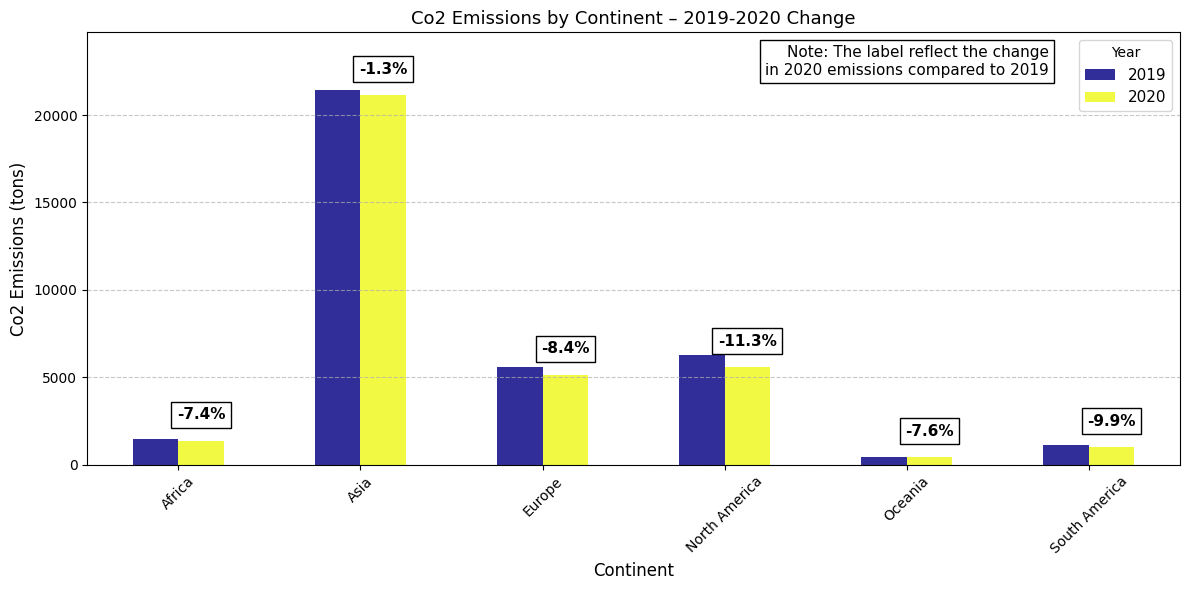

In [98]:
co2_df_folium = co2_df_folium.rename(
    {col: col.strip() for col in co2_df_folium.columns}
)

co2_df_folium = co2_df_folium.with_columns(
    pl.Series(
        "Continent", [get_continent(iso2) for iso2 in co2_df_folium["Abbreviation"]]
    )
)

co2_selected = co2_df_folium.select(["Country", "Continent", "2019", "2020"])

co2_by_continent = co2_selected.group_by("Continent").agg(
    pl.sum("2019").alias("2019"),
    pl.sum("2020").alias("2020"),
)

co2_by_continent = co2_by_continent.with_columns(
    (
        (
            (co2_by_continent["2020"] - co2_by_continent["2019"])
            / co2_by_continent["2019"]
        )
        * 100
    ).alias("Change_Pct_2019_2020"),
)
co2_by_continent = (
    co2_by_continent.to_pandas().sort_values(by="Continent").set_index("Continent")
)

fig, ax = plt.subplots(figsize=(12, 6))
bars = co2_by_continent[["2019", "2020"]].plot(
    kind="bar", colormap="plasma", alpha=0.85, ax=ax
)

for i, continent in enumerate(co2_by_continent.index):
    change_19_20 = co2_by_continent.loc[continent, "Change_Pct_2019_2020"]
    bar_2020 = ax.patches[i + len(co2_by_continent.index)]
    change_label = f"{change_19_20:,.1f}%".replace(",", ".")

    ax.text(
        bar_2020.get_x() + bar_2020.get_width() / 2,
        bar_2020.get_height() + (max(co2_by_continent["2020"]) * 0.05),
        change_label,
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", edgecolor="black"),
    )

ax.text(
    0.88,
    0.97,
    "Note: The label reflect the change\nin 2020 emissions compared to 2019",
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(facecolor="white", edgecolor="black"),
)

plt.legend(title="Year", fontsize=11, loc="upper right")
plt.title("Co2 Emissions by Continent – 2019-2020 Change", fontsize=13)
plt.ylabel("Co2 Emissions (tons)", fontsize=12)
plt.xlabel("Continent", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
plt.tight_layout()
plt.show()

In 2020, North America led the continents in reducing Co2 emissions, achieving an 11.3% decrease. Europe followed with an 8.4% reduction. However, Asia saw the smallest decrease in emissions, at 1.3%. This may be because a significant portion of Asia's energy mix still relies heavily on coal, a high-carbon fuel source.

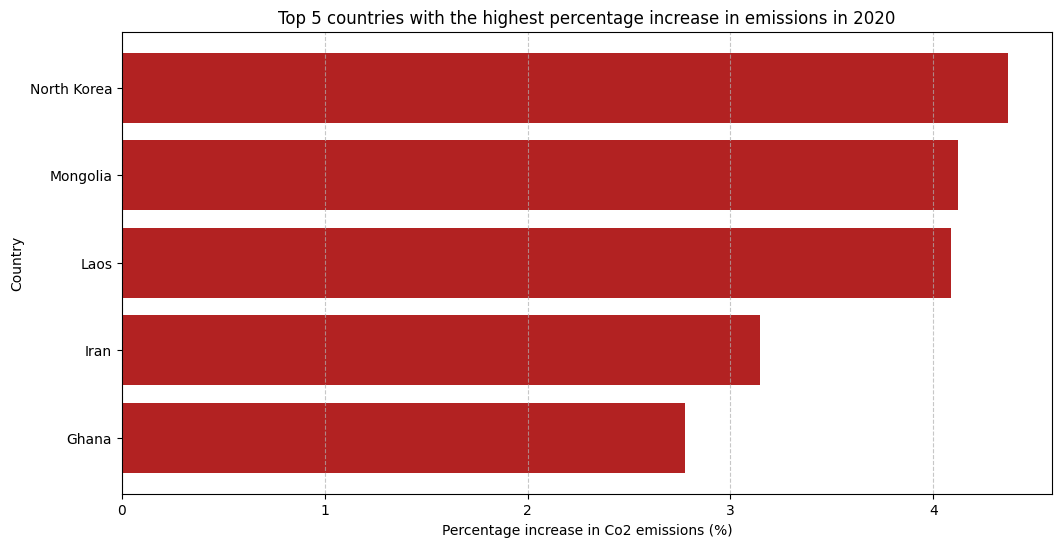

In [99]:
co2_selected = co2_selected.with_columns(
    (
        ((co2_selected["2020"] - co2_selected["2019"]) / co2_selected["2019"]) * 100
    ).alias("Change_Pct_2019_2020")
)

increased_emissions = co2_selected.filter(pl.col("Change_Pct_2019_2020") > 0)
increased_emissions = (
    increased_emissions.sort(by="Change_Pct_2019_2020", descending=True)
    .head(5)
    .to_pandas()
)

plt.figure(figsize=(12, 6))
plt.barh(
    increased_emissions["Country"],
    increased_emissions["Change_Pct_2019_2020"],
    color="firebrick",
)
plt.xlabel("Percentage increase in Co2 emissions (%)")
plt.ylabel("Country")
plt.title("Top 5 countries with the highest percentage increase in emissions in 2020")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

North Korea leads this list by a wide margin, followed by Mongolia, Laos, Iran and Ghana. This divergence from the global trend underscores the fact that national circumstances and policies played a crucial role in shaping emission patterns during the pandemic. The increase in emissions in these countries could be attributed to factors such as continued industrial activity, a reliance on fossil fuels for energy, or a rebound in economic activity following initial lockdowns.

<hr>


Ultimately, we export the Co2 emission for each country to csv format, to be able to add it to the global information dataset in the 01_introduction_and_processing.ipynb notebook

In [100]:
world_df.select(["Country", "Co2-Emissions"]).write_csv(
    "../data/cleaned/co2_exported.csv"
)